# Analysis of Temperature Data
A simple Raspberry Pi and DHT22 Temperature and Humidity sensor

## Import Required libraries

In [1]:
from pprint import pformat as pf, pprint as pp
from datetime import datetime, timezone
import json
import logging
import os

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

import requests
from influxdb import DataFrameClient
import pandas as pd
import numpy as np

import statsmodels
from statsmodels.tsa import stattools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
np.random.seed(3)


import matplotlib.pyplot as plt
import itermplot
%matplotlib inline

print(os.environ.get('MPLBACKEND', ''))
print(statsmodels.__version__)
print(np.__version__)
print(pd.__version__)

module://itermplot
0.10.2
1.17.4
0.25.3


# Fetch Data

In [2]:
client = DataFrameClient(host='192.168.0.156', port=8086, database='metrics')
data =     client.query(
        '''
            SELECT 
                mean("value") 
            FROM "temperature" 
            WHERE 
                ("sensor_id" = 'RPI4-DHT22') 
                AND time >= now() - 90d 
            GROUP BY time(1h) fill(null);
        ''',
        bind_params={}, chunked=True, chunk_size=10000
    )

data = data['temperature']
data.columns = ['value']
data.describe()

,value
count,1770.000000
mean,24.573595
std,2.650213
min,17.413257
25%,22.585243
50%,24.423026
75%,26.691034
max,30.254950


In [3]:
df = data.dropna()
df_temp = df[['value']].resample('H').mean()
df_temp.index

DatetimeIndex(['2019-09-22 07:00:00+00:00', '2019-09-22 08:00:00+00:00',
               '2019-09-22 09:00:00+00:00', '2019-09-22 10:00:00+00:00',
               '2019-09-22 11:00:00+00:00', '2019-09-22 12:00:00+00:00',
               '2019-09-22 13:00:00+00:00', '2019-09-22 14:00:00+00:00',
               '2019-09-22 15:00:00+00:00', '2019-09-22 16:00:00+00:00',
               ...
               '2019-12-07 21:00:00+00:00', '2019-12-07 22:00:00+00:00',
               '2019-12-07 23:00:00+00:00', '2019-12-08 00:00:00+00:00',
               '2019-12-08 01:00:00+00:00', '2019-12-08 02:00:00+00:00',
               '2019-12-08 03:00:00+00:00', '2019-12-08 04:00:00+00:00',
               '2019-12-08 05:00:00+00:00', '2019-12-08 06:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=1848, freq='H')

/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


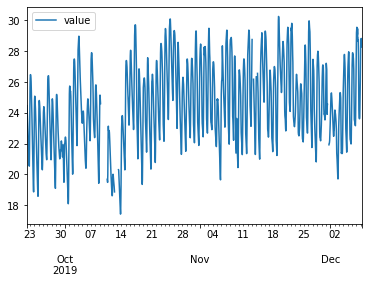

In [4]:
df_temp.plot()

# Differencing

In [5]:
df_diff = df_temp.diff().dropna()

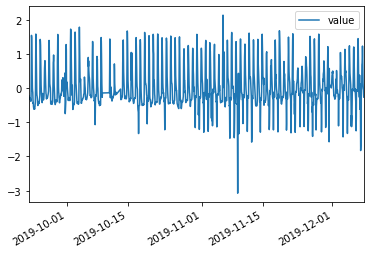

In [6]:
df_diff.plot()

# Stationarity Tests
## Augmented Dickey-Fuller Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller

> Null Hypothesis (H0): Time Series is NOT stationary. 

**adf**: `float`

Test statistic

**pvalue**: `float`

MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)

**usedlag**: `int`

Number of lags used

**nobs**: `int`

Number of observations used for the ADF regression and calculation of the critical values

**critical values**: `dict`

Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010)

**icbest**: `float`
The maximized information criterion if autolag is not None.

In [7]:
print("TEMPERATURE")
results = stattools.adfuller(df_temp['value'].dropna())

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

TEMPERATURE
p-value: 6.269868243814316e-05
Reject H0. Reject non-stationary. It could be stationary.


In [8]:
print("DIFFERENCED")
results = stattools.adfuller(df_diff['value'].dropna())

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

DIFFERENCED
p-value: 6.9016381417147905e-15
Reject H0. Reject non-stationary. It could be stationary.


## KPSS Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html#statsmodels.tsa.stattools.kpss

> Null Hypothesis (H0): Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary.

**kpss_stat**: `float`

The KPSS test statistic

**p_value**: `float`

The p-value of the test. The p-value is interpolated from Table 1 in Kwiatkowski et al. (1992), and a boundary point is returned if the test statistic is outside the table of critical values, that is, if the p-value is outside the interval (0.01, 0.1).

**lags**: `int`

The truncation lag parameter

**crit**: `dict`

The critical values at 10%, 5%, 2.5% and 1%. Based on Kwiatkowski et al. (1992).


In [9]:
print("TEMPERATURE")
results = stattools.kpss(df_temp['value'].dropna(), regression='ct', lags='auto')

kpss_stat, pvalue, lags, critical_values = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject stationary. It could be non-stationary.")
else:
    print("Could not reject H0. It is likely stationary.")

TEMPERATURE
p-value: 0.01
Reject H0. Reject stationary. It could be non-stationary.


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [10]:
print("DIFFERENCED")
results = stattools.kpss(df_diff['value'].dropna(), regression='ct', lags='auto')

kpss_stat, pvalue, lags, critical_values = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject stationary. It could be non-stationary.")
else:
    print("Could not reject H0. It is likely stationary.")

DIFFERENCED
p-value: 0.1
Could not reject H0. It is likely stationary.


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


# Auto Correlation Plots

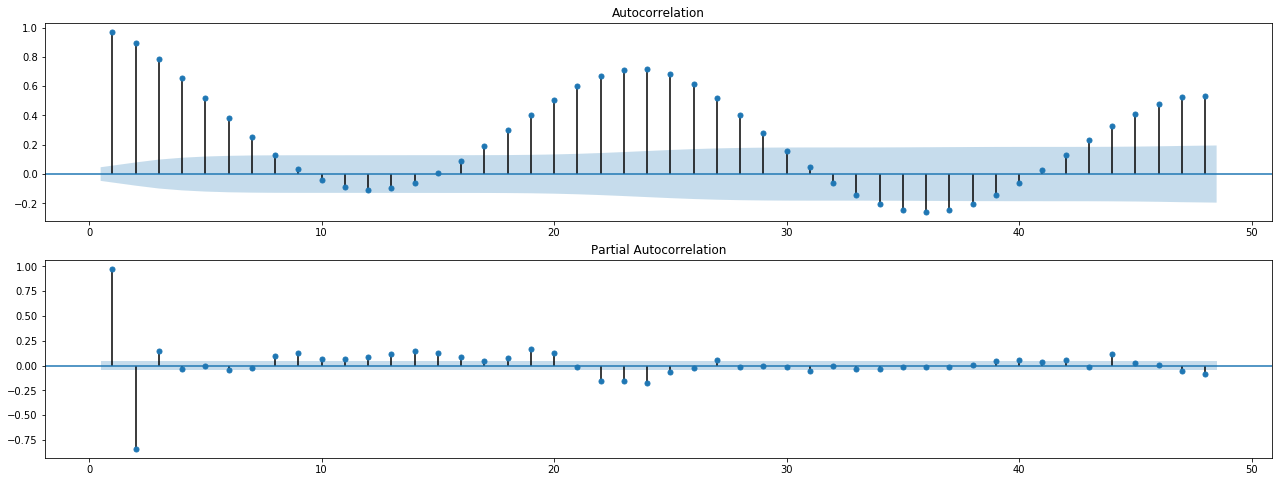

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(22,8))
plot_acf(df_temp.dropna(), lags=48, zero=False, ax=ax1)
plot_pacf(df_temp.dropna(), lags=48, zero=False, ax=ax2)
plt.show()

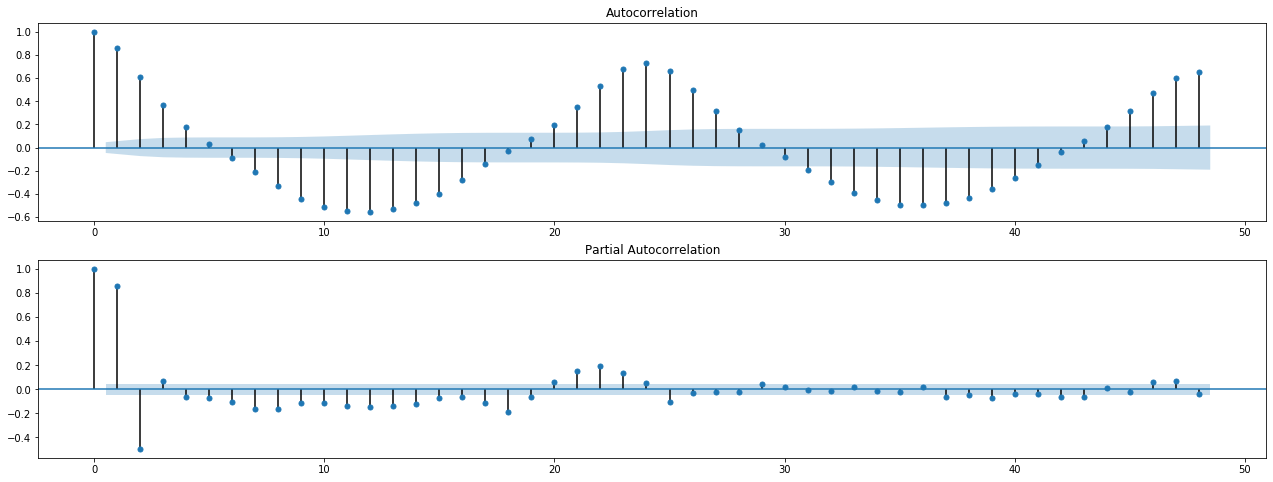

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(22,8))
plot_acf(df_diff.dropna(), lags=48, zero=True, ax=ax1)
plot_pacf(df_diff.dropna(), lags=48, zero=True, ax=ax2)
plt.show()

## ACF

The Auto Correlation Function, has strong correlation at lags 12, 24, 36 but overall decays slowly.

## PACF

The Partial Auto Correlation function drops off rapidly after 2 lags which suggests a strong Auto Regressive relationship. 

Lets look at fitting an ARIMA model next.

# SARIMAX

First we will look at a seasonal decomposition, followed by and exhaustive search of parameters minimizing for the AIC and BIC.

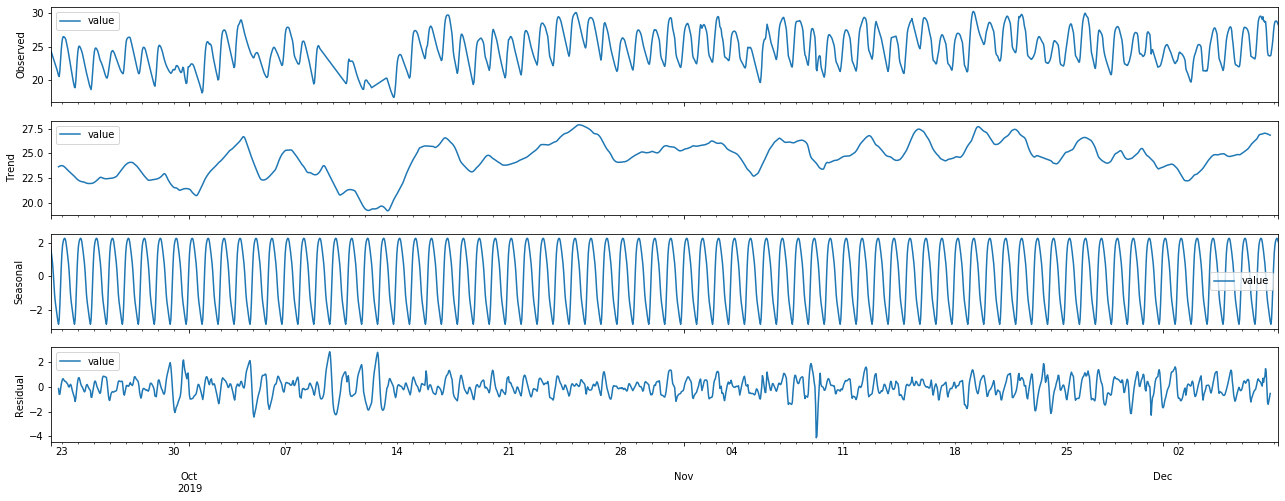

In [13]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(22,8))
decomp = seasonal_decompose(df_temp.interpolate().resample('H').mean())

decomp.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')

decomp.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')

decomp.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')

decomp.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residual')
plt.show()


In [ ]:
# WARNING: THIS STEP CAN TAKE 12 HOURS
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from multiprocessing import Pool

from itertools import product

# Setup list of experiments

seasonal_list = list(product(range(0,5),[0,1],range(0,5), [12,24]))
non_seasonal_list = list(product(range(1,5),[1],range(1,5)))
pdqPDQS = list(product(seasonal_list, non_seasonal_list))

print(len(seasonal_list))
print(len(non_seasonal_list))
print(len(pdqPDQS))
start = datetime.now()
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'))

# Define a fitting task
def fit_sarimax(pdqPDQS):
    non_seasonal = pdqPDQS[1]
    seasonal = pdqPDQS[0]
    try:
        model = SARIMAX(df_temp['value'], order=non_seasonal, seasonal_order=seasonal)
        results = model.fit()
        #print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'), non_seasonal, seasonal, results.aic, results.bic)
        return (non_seasonal, seasonal, results.aic, results.bic)
    except:
        #print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'), non_seasonal, seasonal, None, None)
        return (non_seasonal, seasonal, None, None)

order_aic_bic = []
with ThreadPoolExecutor() as pool:
    for result in pool.map(fit_sarimax, pdqPDQS):
        order_aic_bic.append(result)
    
print("EVALUATING")
order_aic_bic


In [35]:
order_df = pd.DataFrame(order_aic_bic, columns=['pdq','PDQS','aic', 'bic'])
order_df.sort_values('aic').head(10)

,pdq,PDQS,aic,bic
1027,"(1, 1, 4)","(3, 0, 2, 12)",-419.103745,-358.369248
723,"(1, 1, 4)","(2, 0, 2, 24)",-418.983051,-363.769871
1407,"(4, 1, 4)","(4, 0, 3, 24)",-418.358685,-330.017597
1342,"(4, 1, 3)","(4, 0, 1, 24)",-418.135212,-346.358078
719,"(4, 1, 4)","(2, 0, 2, 12)",-417.995868,-346.218734
1022,"(4, 1, 3)","(3, 0, 1, 24)",-417.840732,-351.584916
859,"(3, 1, 4)","(2, 1, 1, 24)",-417.631472,-357.040845
383,"(4, 1, 4)","(1, 0, 1, 24)",-417.625853,-356.891355
219,"(3, 1, 4)","(0, 1, 1, 24)",-417.599878,-368.025729
1439,"(4, 1, 4)","(4, 0, 4, 24)",-417.502771,-323.640365


In [34]:
order_df.sort_values('bic').head(10)

,pdq,PDQS,aic,bic
211,"(1, 1, 4)","(0, 1, 1, 24)",-417.003107,-378.445436
214,"(2, 1, 3)","(0, 1, 1, 24)",-415.531606,-376.973934
531,"(1, 1, 4)","(1, 1, 1, 24)",-416.090172,-372.024262
215,"(2, 1, 4)","(0, 1, 1, 24)",-414.385634,-370.319724
218,"(3, 1, 3)","(0, 1, 1, 24)",-413.725938,-369.660028
243,"(1, 1, 4)","(0, 1, 2, 24)",-413.701126,-369.635216
534,"(2, 1, 3)","(1, 1, 1, 24)",-412.765722,-368.699811
373,"(2, 1, 2)","(1, 0, 1, 24)",-406.932681,-368.283455
219,"(3, 1, 4)","(0, 1, 1, 24)",-417.599878,-368.025729
246,"(2, 1, 3)","(0, 1, 2, 24)",-411.797700,-367.731790


In [48]:
pdq = (3,1,4)
PDQS = (0,1,1,24)
model = SARIMAX(df_temp['value'], order=pdq, seasonal_order=PDQS)
results = model.fit()
results.summary()

/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              value   No. Observations:                 1848
Model:             SARIMAX(3, 1, 4)x(0, 1, 1, 24)   Log Likelihood                 217.800
Date:                            Fri, 13 Dec 2019   AIC                           -417.600
Time:                                    11:00:52   BIC                           -368.026
Sample:                                09-22-2019   HQIC                          -399.312
                                     - 12-08-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2288      0.078      2.950      0.003       0.077       0.381
ar.L2          0.8878      0.092      9.688      0.000       0.708       1.067
ar.L3         -0.1791      0.049     -3.691      0.000      -0.274      -0.084
ma.L1          0.6726      0.080      8.452      0.000       0.517       0.829
ma.L2         -0.7091      0.047    -15.197      0.000      -0.801      -0.618
ma.L3         -0.6996      0.049    -14.142      0.000      -0.797      -0.603
ma.L4         -0.2612      0.032     -8.168      0.000      -0.324      -0.199
ma.S.L24      -0.9203      0.009   -103.009      0.000      -0.938      -0.903
sigma2         0.0435      0.001     67.460      0.000       0.042       0.045
===================================================================================
Ljung-Box (Q):                       57.33   Jarque-Bera (JB):             13390.84
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

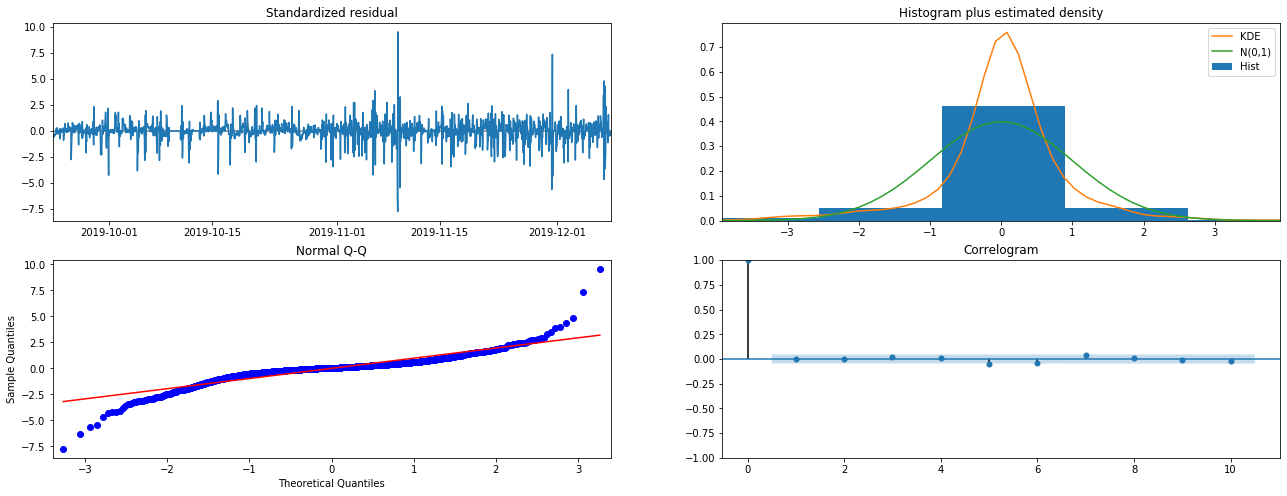

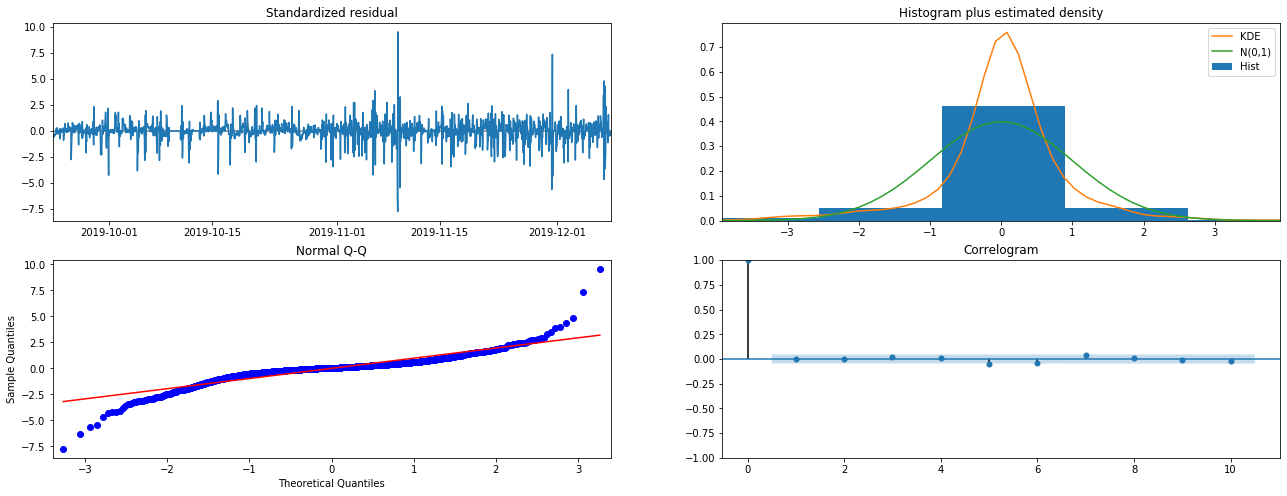

In [49]:
results.plot_diagnostics(figsize=(22,8))

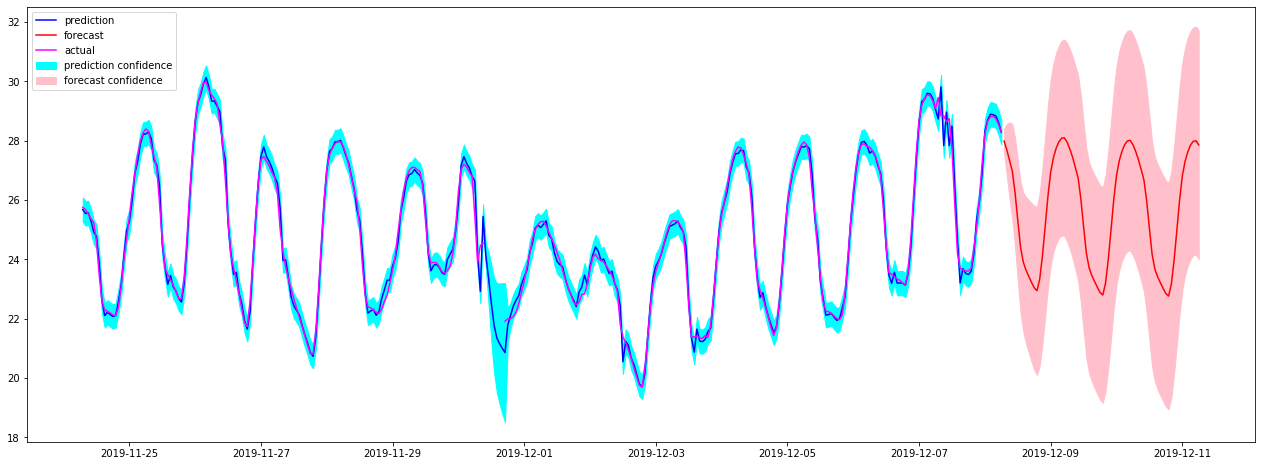

In [50]:
lookback = -1 * 24 * 14
lookahead = 24 * 3
actual = df_temp[lookback:]

prediction = results.get_prediction(start=lookback, dynamic=False)
prediction_mean = prediction.predicted_mean
prediction_ci = prediction.conf_int()

forecast = results.get_forecast(steps=lookahead, dynamic=True)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(22,8))



plt.plot(
    prediction_mean.index, 
    prediction_mean.values, 
    color='blue', 
    label='prediction'
)
plt.fill_between(
    prediction_ci.index, 
    prediction_ci['lower value'], 
    prediction_ci['upper value'], 
    color='cyan',
    label='prediction confidence'
)

plt.plot(
    forecast_mean.index, 
    forecast_mean.values, 
    color='red', 
    label='forecast'
)
plt.fill_between(
    forecast_ci.index, 
    forecast_ci['lower value'], 
    forecast_ci['upper value'], 
    color='pink',
    label='forecast confidence'
)

plt.plot(
    actual.index,
    actual['value'],
    color='magenta', 
    label='actual'
)
plt.legend(loc="upper left")
plt.show()